In [1]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [5]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [6]:
df = pd.read_csv("Tetuan City power consumption.csv")

In [7]:
from datetime import datetime

In [8]:
#Converting object to datetime datatype

df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce') 

In [9]:
#transforming DateTime column into index
df = df.set_index('DateTime')

In [10]:
del df["Zone 2  Power Consumption"]


In [11]:
del df["Zone 3  Power Consumption"]

In [12]:
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption
DateTime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620
...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452


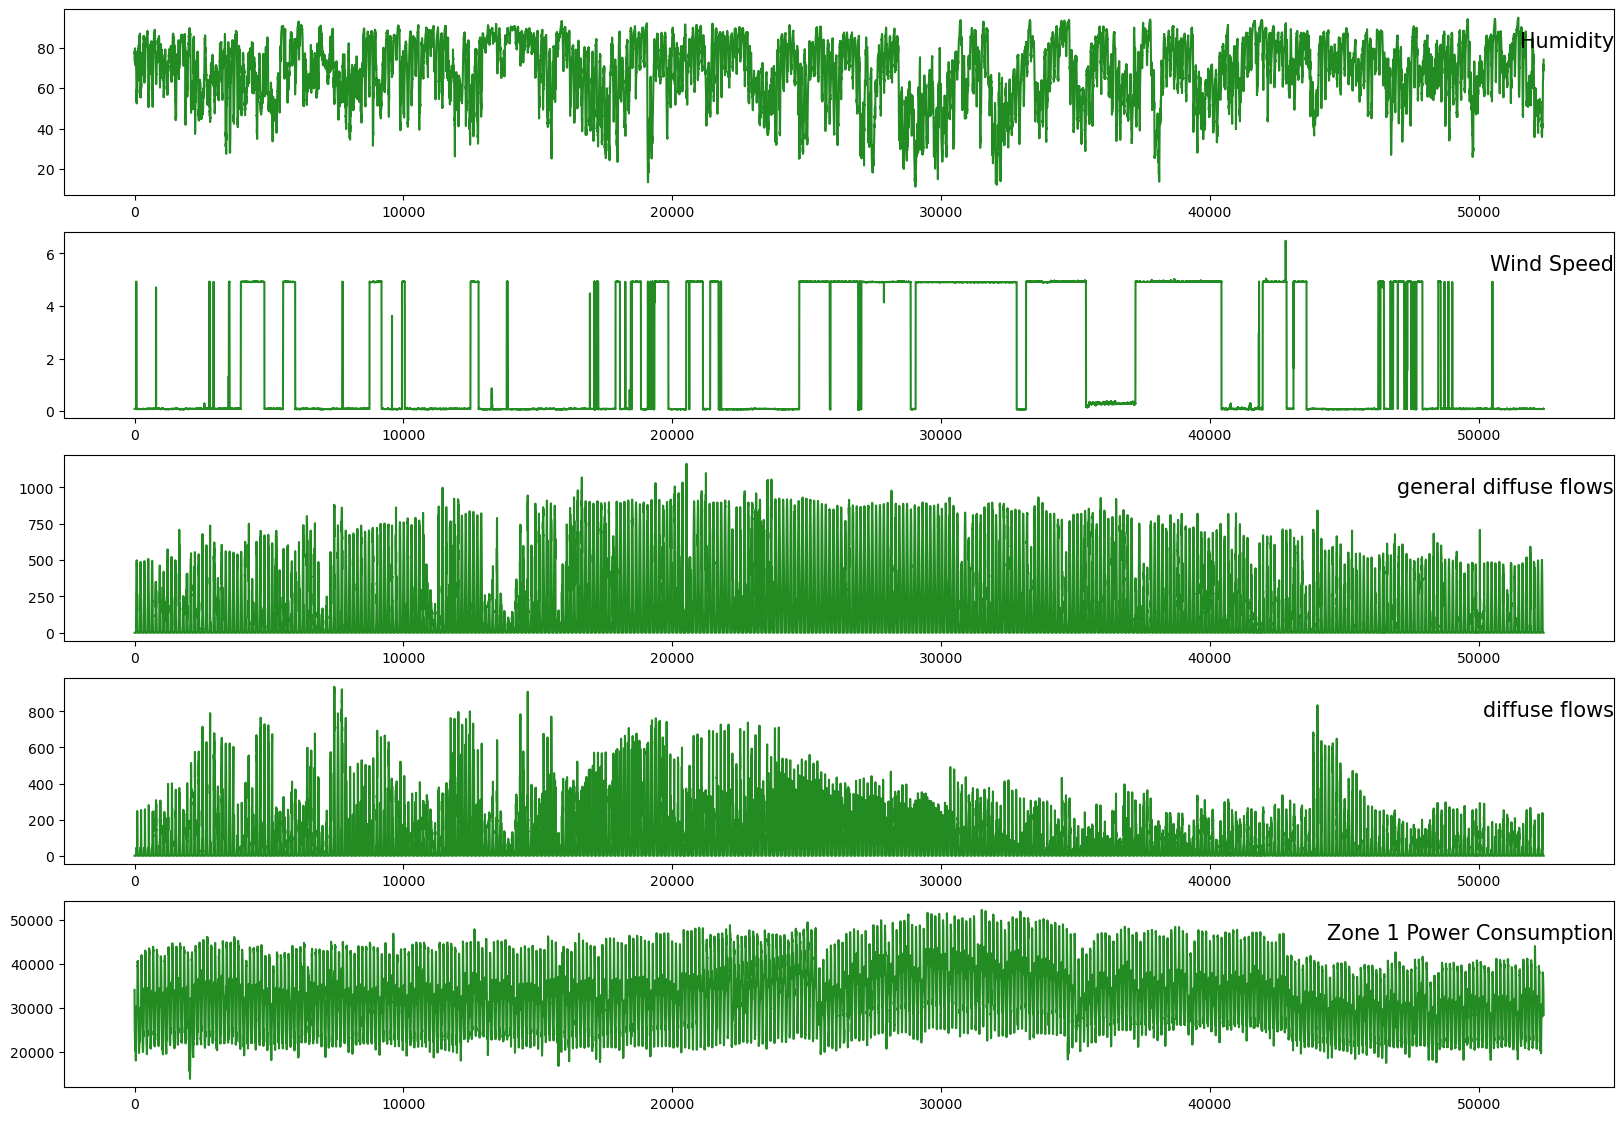

In [13]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 4, 5]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

In [14]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [15]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(52415, 12)


In [16]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [17]:
len(reframed.columns)

12

In [18]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var6(t)
1   0.090091   0.748382   0.005130   0.000040   0.000115   0.526251  0.415545
2   0.086146   0.756770   0.005130   0.000057   0.000079   0.415545  0.397623
3   0.083399   0.756770   0.004663   0.000050   0.000095   0.397623  0.374149
4   0.078176   0.762761   0.005130   0.000075   0.000091   0.374149  0.350834
5   0.072736   0.771148   0.004819   0.000038   0.000079   0.350834  0.332277


### Splitting the training data given into training and testing data for now.

In [19]:
values = reframed.values

# chia theo phut trong nam 2017 va lay 80% de train 20% test
n_train_minutes = 41932

train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(41932, 1, 6) (41932,) (10483, 1, 6) (10483,)


# Designing some neural nets and training them
### Creating and testing on a model, which has about 64 LSTM units

# không thêm Dropout


In [20]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 3s - loss: 0.0086 - val_loss: 5.0167e-04 - 3s/epoch - 2ms/step
Epoch 2/100
1119/1119 - 1s - loss: 2.9747e-04 - val_loss: 2.8673e-04 - 1s/epoch - 1ms/step
Epoch 3/100
1119/1119 - 1s - loss: 2.7753e-04 - val_loss: 4.0714e-04 - 1s/epoch - 1ms/step
Epoch 4/100
1119/1119 - 1s - loss: 2.7367e-04 - val_loss: 3.5836e-04 - 1s/epoch - 1ms/step
Epoch 5/100
1119/1119 - 1s - loss: 2.7445e-04 - val_loss: 3.5358e-04 - 1s/epoch - 1ms/step
Epoch 6/100
1119/1119 - 1s - loss: 2.7325e-04 - val_loss: 3.5177e-04 - 1s/epoch - 1ms/step
Epoch 7/100
1119/1119 - 1s - loss: 2.7140e-04 - val_loss: 3.4410e-04 - 1s/epoch - 1ms/step
Epoch 8/100
1119/1119 - 1s - loss: 2.6931e-04 - val_loss: 3.3566e-04 - 1s/epoch - 1ms/step
Epoch 9/100
1119/1119 - 1s - loss: 2.6738e-04 - val_loss: 3.2810e-04 - 1s/epoch - 1ms/step
Epoch 10/100
1119/1119 - 1s - loss: 2.6572e-04 - val_loss: 3.2148e-04 - 1s/epoch - 1ms/step
Epoch 11/100
1119/1119 - 1s - loss: 2.6429e-04 - val_loss: 3.1559e-04 - 1s/epoch - 1ms/step
E

Epoch 91/100
1119/1119 - 1s - loss: 2.0575e-04 - val_loss: 1.9989e-04 - 1s/epoch - 1ms/step
Epoch 92/100
1119/1119 - 1s - loss: 2.0563e-04 - val_loss: 1.9959e-04 - 1s/epoch - 1ms/step
Epoch 93/100
1119/1119 - 1s - loss: 2.0552e-04 - val_loss: 1.9931e-04 - 1s/epoch - 1ms/step
Epoch 94/100
1119/1119 - 1s - loss: 2.0541e-04 - val_loss: 1.9903e-04 - 1s/epoch - 1ms/step
Epoch 95/100
1119/1119 - 1s - loss: 2.0530e-04 - val_loss: 1.9876e-04 - 1s/epoch - 1ms/step
Epoch 96/100
1119/1119 - 1s - loss: 2.0520e-04 - val_loss: 1.9850e-04 - 1s/epoch - 1ms/step
Epoch 97/100
1119/1119 - 1s - loss: 2.0510e-04 - val_loss: 1.9824e-04 - 1s/epoch - 1ms/step
Epoch 98/100
1119/1119 - 1s - loss: 2.0501e-04 - val_loss: 1.9799e-04 - 1s/epoch - 1ms/step
Epoch 99/100
1119/1119 - 1s - loss: 2.0492e-04 - val_loss: 1.9774e-04 - 1s/epoch - 1ms/step
Epoch 100/100
1119/1119 - 1s - loss: 2.0483e-04 - val_loss: 1.9749e-04 - 1s/epoch - 1ms/step


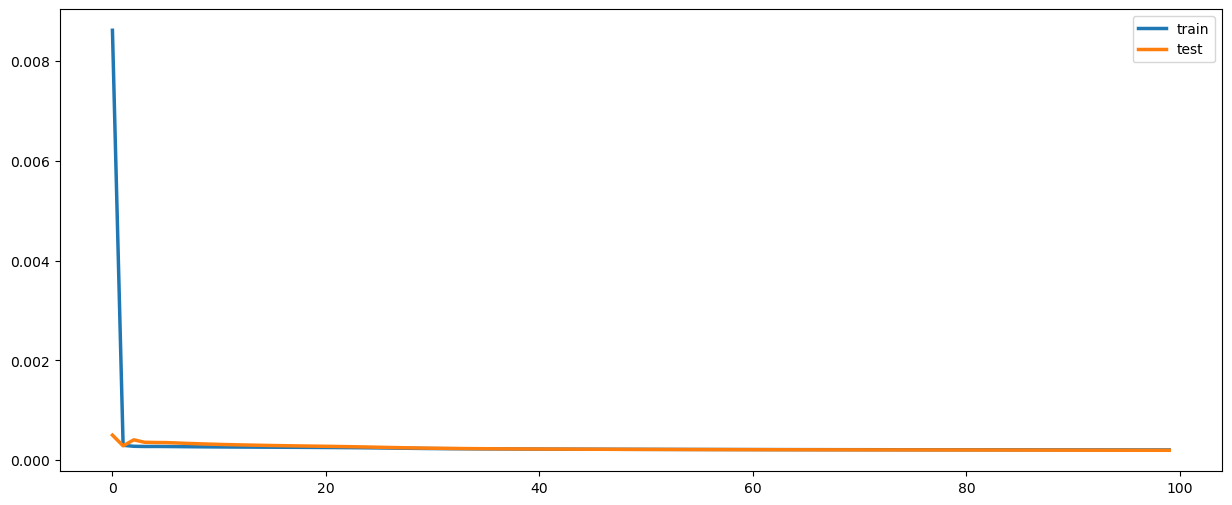

In [21]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [22]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 594us/step


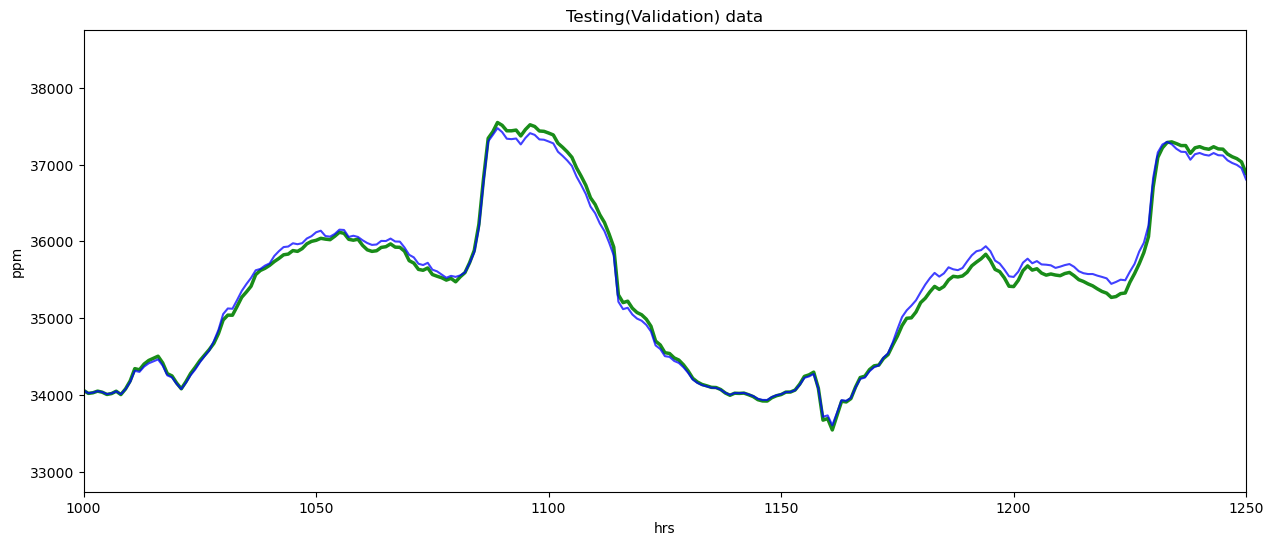

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [24]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 84.308426
MAPE: 0.20313523709774017 %


## Giảm số lượng epochs

In [25]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
1119/1119 - 3s - loss: 0.0098 - val_loss: 4.3262e-04 - 3s/epoch - 2ms/step
Epoch 2/50
1119/1119 - 1s - loss: 3.0466e-04 - val_loss: 2.7561e-04 - 1s/epoch - 1ms/step
Epoch 3/50
1119/1119 - 1s - loss: 2.7662e-04 - val_loss: 3.3102e-04 - 1s/epoch - 1ms/step
Epoch 4/50
1119/1119 - 1s - loss: 2.7155e-04 - val_loss: 3.2453e-04 - 1s/epoch - 1ms/step
Epoch 5/50
1119/1119 - 1s - loss: 2.7162e-04 - val_loss: 3.2453e-04 - 1s/epoch - 1ms/step
Epoch 6/50
1119/1119 - 1s - loss: 2.7212e-04 - val_loss: 3.3003e-04 - 1s/epoch - 1ms/step
Epoch 7/50
1119/1119 - 1s - loss: 2.7077e-04 - val_loss: 3.2591e-04 - 1s/epoch - 1ms/step
Epoch 8/50
1119/1119 - 1s - loss: 2.6868e-04 - val_loss: 3.2032e-04 - 1s/epoch - 1ms/step
Epoch 9/50
1119/1119 - 1s - loss: 2.6661e-04 - val_loss: 3.1502e-04 - 1s/epoch - 1ms/step
Epoch 10/50
1119/1119 - 1s - loss: 2.6476e-04 - val_loss: 3.1011e-04 - 1s/epoch - 1ms/step
Epoch 11/50
1119/1119 - 1s - loss: 2.6312e-04 - val_loss: 3.0558e-04 - 1s/epoch - 1ms/step
Epoch 12/50


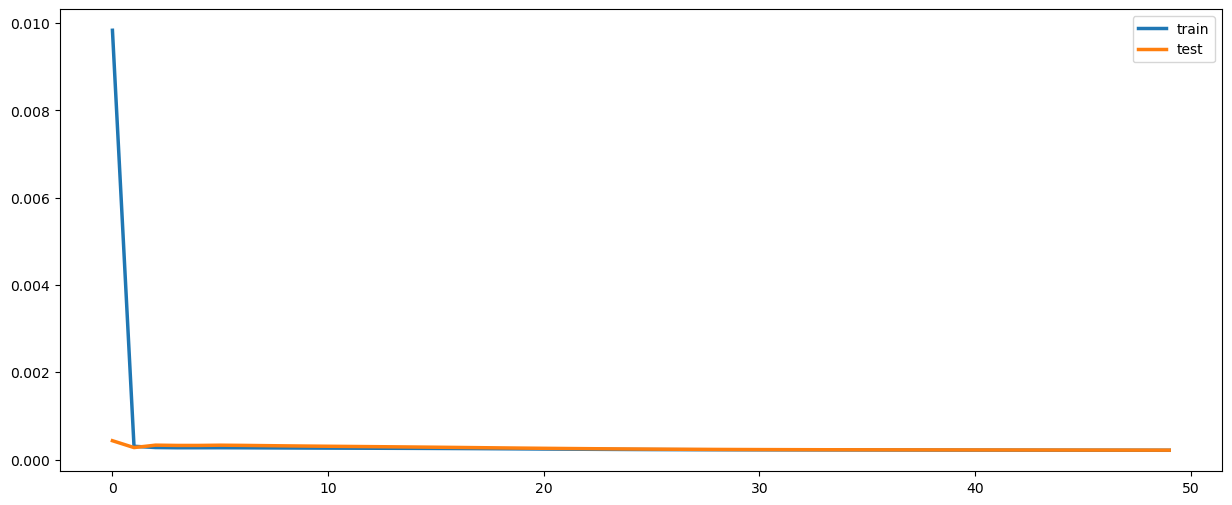

In [26]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [27]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 600us/step


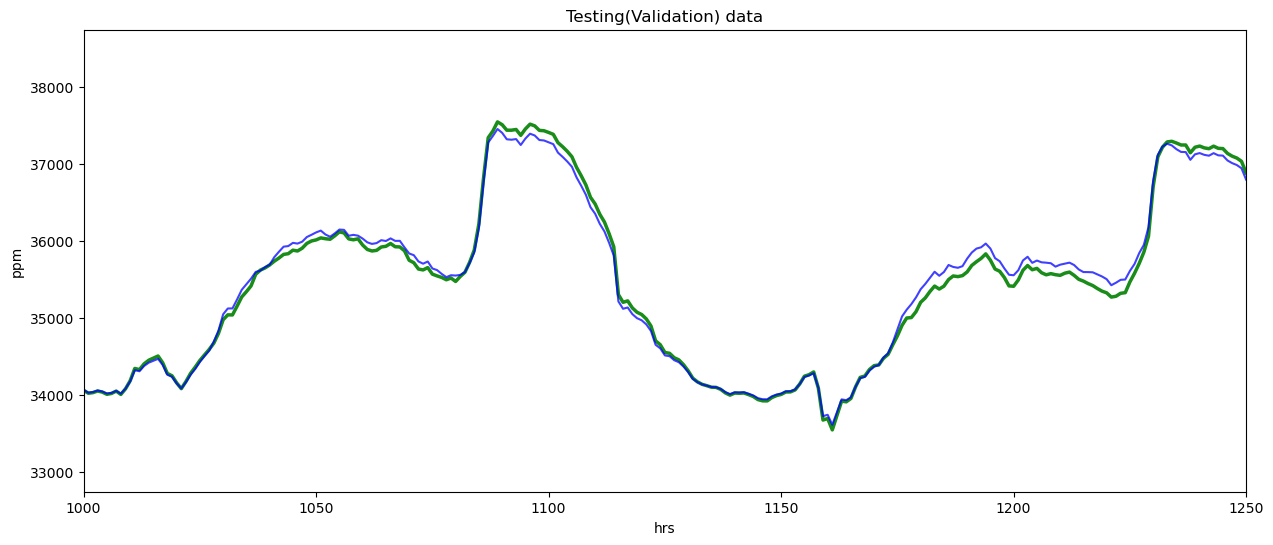

In [28]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [29]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 95.01734
MAPE: 0.22975611500442028 %


## Tăng số lượng epochs

In [30]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/150
1119/1119 - 2s - loss: 0.0086 - val_loss: 5.4512e-04 - 2s/epoch - 2ms/step
Epoch 2/150
1119/1119 - 1s - loss: 3.0999e-04 - val_loss: 2.7978e-04 - 1s/epoch - 1ms/step
Epoch 3/150
1119/1119 - 1s - loss: 2.8183e-04 - val_loss: 3.5580e-04 - 1s/epoch - 1ms/step
Epoch 4/150
1119/1119 - 1s - loss: 2.7883e-04 - val_loss: 3.3589e-04 - 1s/epoch - 1ms/step
Epoch 5/150
1119/1119 - 1s - loss: 2.7929e-04 - val_loss: 3.3550e-04 - 1s/epoch - 1ms/step
Epoch 6/150
1119/1119 - 1s - loss: 2.7542e-04 - val_loss: 3.4651e-04 - 1s/epoch - 1ms/step
Epoch 7/150
1119/1119 - 1s - loss: 2.7225e-04 - val_loss: 3.4657e-04 - 1s/epoch - 1ms/step
Epoch 8/150
1119/1119 - 1s - loss: 2.6955e-04 - val_loss: 3.4206e-04 - 1s/epoch - 1ms/step
Epoch 9/150
1119/1119 - 1s - loss: 2.6721e-04 - val_loss: 3.3594e-04 - 1s/epoch - 1ms/step
Epoch 10/150
1119/1119 - 1s - loss: 2.6516e-04 - val_loss: 3.2925e-04 - 1s/epoch - 1ms/step
Epoch 11/150
1119/1119 - 1s - loss: 2.6330e-04 - val_loss: 3.2237e-04 - 1s/epoch - 1ms/step
E

Epoch 91/150
1119/1119 - 1s - loss: 2.0510e-04 - val_loss: 2.0011e-04 - 1s/epoch - 1ms/step
Epoch 92/150
1119/1119 - 1s - loss: 2.0501e-04 - val_loss: 1.9975e-04 - 1s/epoch - 1ms/step
Epoch 93/150
1119/1119 - 1s - loss: 2.0492e-04 - val_loss: 1.9941e-04 - 1s/epoch - 1ms/step
Epoch 94/150
1119/1119 - 1s - loss: 2.0483e-04 - val_loss: 1.9906e-04 - 1s/epoch - 1ms/step
Epoch 95/150
1119/1119 - 1s - loss: 2.0475e-04 - val_loss: 1.9871e-04 - 1s/epoch - 1ms/step
Epoch 96/150
1119/1119 - 1s - loss: 2.0466e-04 - val_loss: 1.9837e-04 - 1s/epoch - 1ms/step
Epoch 97/150
1119/1119 - 1s - loss: 2.0458e-04 - val_loss: 1.9803e-04 - 1s/epoch - 1ms/step
Epoch 98/150
1119/1119 - 1s - loss: 2.0450e-04 - val_loss: 1.9769e-04 - 1s/epoch - 1ms/step
Epoch 99/150
1119/1119 - 1s - loss: 2.0443e-04 - val_loss: 1.9737e-04 - 1s/epoch - 1ms/step
Epoch 100/150
1119/1119 - 1s - loss: 2.0435e-04 - val_loss: 1.9706e-04 - 1s/epoch - 1ms/step
Epoch 101/150
1119/1119 - 1s - loss: 2.0428e-04 - val_loss: 1.9675e-04 - 1s/epo

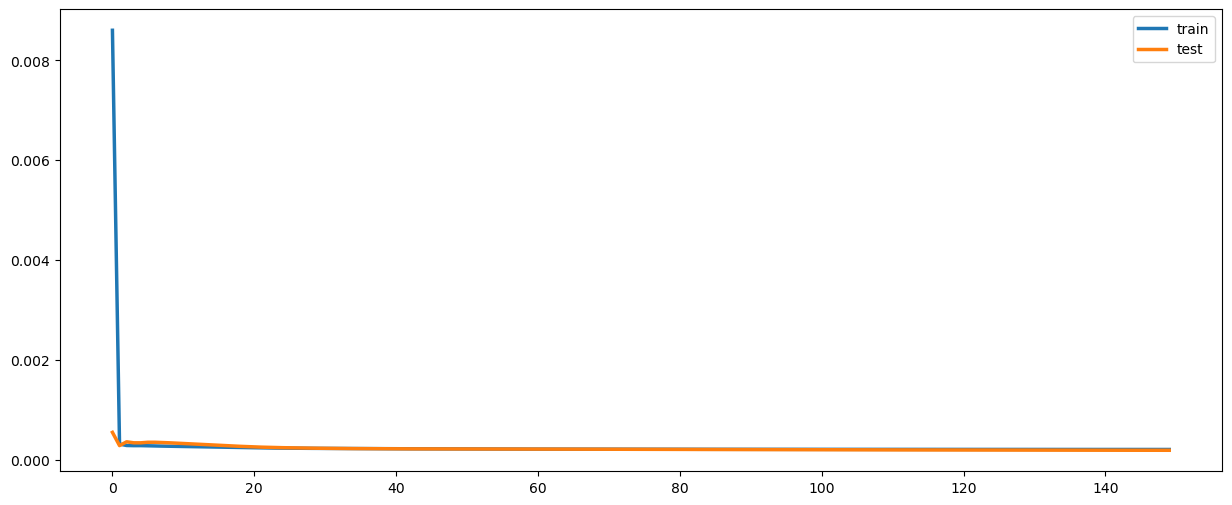

In [31]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [32]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 576us/step


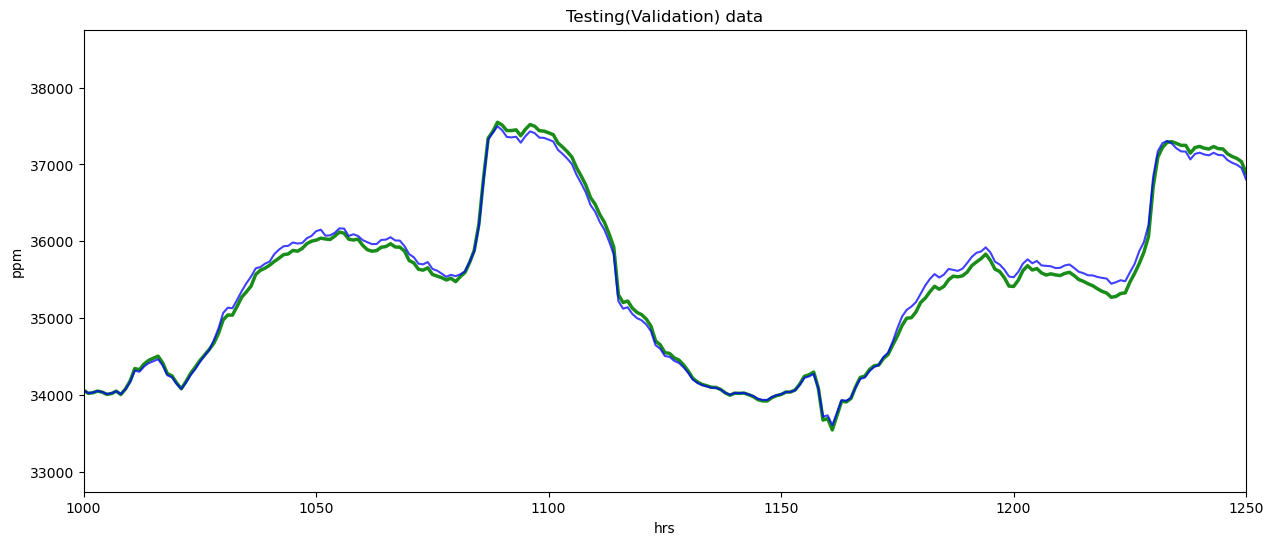

In [33]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [34]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 79.10496
MAPE: 0.1918949536047876 %


## tăng số lượng epochs

In [35]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/300
1119/1119 - 2s - loss: 0.0086 - val_loss: 4.5768e-04 - 2s/epoch - 2ms/step
Epoch 2/300
1119/1119 - 1s - loss: 3.0853e-04 - val_loss: 2.7172e-04 - 1s/epoch - 1ms/step
Epoch 3/300
1119/1119 - 1s - loss: 2.7947e-04 - val_loss: 3.5905e-04 - 1s/epoch - 1ms/step
Epoch 4/300
1119/1119 - 1s - loss: 2.7547e-04 - val_loss: 3.7029e-04 - 1s/epoch - 1ms/step
Epoch 5/300
1119/1119 - 1s - loss: 2.7645e-04 - val_loss: 3.5463e-04 - 1s/epoch - 1ms/step
Epoch 6/300
1119/1119 - 1s - loss: 2.7403e-04 - val_loss: 3.5815e-04 - 1s/epoch - 1ms/step
Epoch 7/300
1119/1119 - 1s - loss: 2.7171e-04 - val_loss: 3.5394e-04 - 1s/epoch - 1ms/step
Epoch 8/300
1119/1119 - 1s - loss: 2.6937e-04 - val_loss: 3.4700e-04 - 1s/epoch - 1ms/step
Epoch 9/300
1119/1119 - 1s - loss: 2.6725e-04 - val_loss: 3.3962e-04 - 1s/epoch - 1ms/step
Epoch 10/300
1119/1119 - 1s - loss: 2.6538e-04 - val_loss: 3.3236e-04 - 1s/epoch - 1ms/step
Epoch 11/300
1119/1119 - 1s - loss: 2.6371e-04 - val_loss: 3.2530e-04 - 1s/epoch - 1ms/step
E

Epoch 91/300
1119/1119 - 1s - loss: 2.0526e-04 - val_loss: 2.0129e-04 - 1s/epoch - 1ms/step
Epoch 92/300
1119/1119 - 1s - loss: 2.0516e-04 - val_loss: 2.0103e-04 - 1s/epoch - 1ms/step
Epoch 93/300
1119/1119 - 1s - loss: 2.0507e-04 - val_loss: 2.0077e-04 - 1s/epoch - 1ms/step
Epoch 94/300
1119/1119 - 1s - loss: 2.0498e-04 - val_loss: 2.0050e-04 - 1s/epoch - 1ms/step
Epoch 95/300
1119/1119 - 1s - loss: 2.0489e-04 - val_loss: 2.0025e-04 - 1s/epoch - 1ms/step
Epoch 96/300
1119/1119 - 1s - loss: 2.0481e-04 - val_loss: 1.9999e-04 - 1s/epoch - 1ms/step
Epoch 97/300
1119/1119 - 1s - loss: 2.0472e-04 - val_loss: 1.9973e-04 - 1s/epoch - 1ms/step
Epoch 98/300
1119/1119 - 1s - loss: 2.0464e-04 - val_loss: 1.9948e-04 - 1s/epoch - 1ms/step
Epoch 99/300
1119/1119 - 1s - loss: 2.0456e-04 - val_loss: 1.9922e-04 - 1s/epoch - 1ms/step
Epoch 100/300
1119/1119 - 1s - loss: 2.0448e-04 - val_loss: 1.9897e-04 - 1s/epoch - 1ms/step
Epoch 101/300
1119/1119 - 1s - loss: 2.0440e-04 - val_loss: 1.9873e-04 - 1s/epo

Epoch 180/300
1119/1119 - 1s - loss: 2.0149e-04 - val_loss: 1.8609e-04 - 1s/epoch - 1ms/step
Epoch 181/300
1119/1119 - 1s - loss: 2.0147e-04 - val_loss: 1.8606e-04 - 1s/epoch - 1ms/step
Epoch 182/300
1119/1119 - 1s - loss: 2.0145e-04 - val_loss: 1.8603e-04 - 1s/epoch - 1ms/step
Epoch 183/300
1119/1119 - 1s - loss: 2.0143e-04 - val_loss: 1.8601e-04 - 1s/epoch - 1ms/step
Epoch 184/300
1119/1119 - 1s - loss: 2.0141e-04 - val_loss: 1.8599e-04 - 1s/epoch - 1ms/step
Epoch 185/300
1119/1119 - 1s - loss: 2.0139e-04 - val_loss: 1.8596e-04 - 1s/epoch - 1ms/step
Epoch 186/300
1119/1119 - 1s - loss: 2.0137e-04 - val_loss: 1.8595e-04 - 1s/epoch - 1ms/step
Epoch 187/300
1119/1119 - 1s - loss: 2.0135e-04 - val_loss: 1.8593e-04 - 1s/epoch - 1ms/step
Epoch 188/300
1119/1119 - 1s - loss: 2.0133e-04 - val_loss: 1.8591e-04 - 1s/epoch - 1ms/step
Epoch 189/300
1119/1119 - 1s - loss: 2.0131e-04 - val_loss: 1.8590e-04 - 1s/epoch - 1ms/step
Epoch 190/300
1119/1119 - 1s - loss: 2.0128e-04 - val_loss: 1.8589e-04

1119/1119 - 1s - loss: 1.9362e-04 - val_loss: 1.8184e-04 - 1s/epoch - 1ms/step
Epoch 269/300
1119/1119 - 1s - loss: 1.9353e-04 - val_loss: 1.8174e-04 - 1s/epoch - 1ms/step
Epoch 270/300
1119/1119 - 1s - loss: 1.9345e-04 - val_loss: 1.8165e-04 - 1s/epoch - 1ms/step
Epoch 271/300
1119/1119 - 1s - loss: 1.9337e-04 - val_loss: 1.8156e-04 - 1s/epoch - 1ms/step
Epoch 272/300
1119/1119 - 1s - loss: 1.9329e-04 - val_loss: 1.8147e-04 - 1s/epoch - 1ms/step
Epoch 273/300
1119/1119 - 1s - loss: 1.9322e-04 - val_loss: 1.8138e-04 - 1s/epoch - 1ms/step
Epoch 274/300
1119/1119 - 1s - loss: 1.9315e-04 - val_loss: 1.8129e-04 - 1s/epoch - 1ms/step
Epoch 275/300
1119/1119 - 1s - loss: 1.9308e-04 - val_loss: 1.8121e-04 - 1s/epoch - 1ms/step
Epoch 276/300
1119/1119 - 1s - loss: 1.9301e-04 - val_loss: 1.8113e-04 - 1s/epoch - 1ms/step
Epoch 277/300
1119/1119 - 1s - loss: 1.9295e-04 - val_loss: 1.8105e-04 - 1s/epoch - 1ms/step
Epoch 278/300
1119/1119 - 1s - loss: 1.9288e-04 - val_loss: 1.8098e-04 - 1s/epoch - 

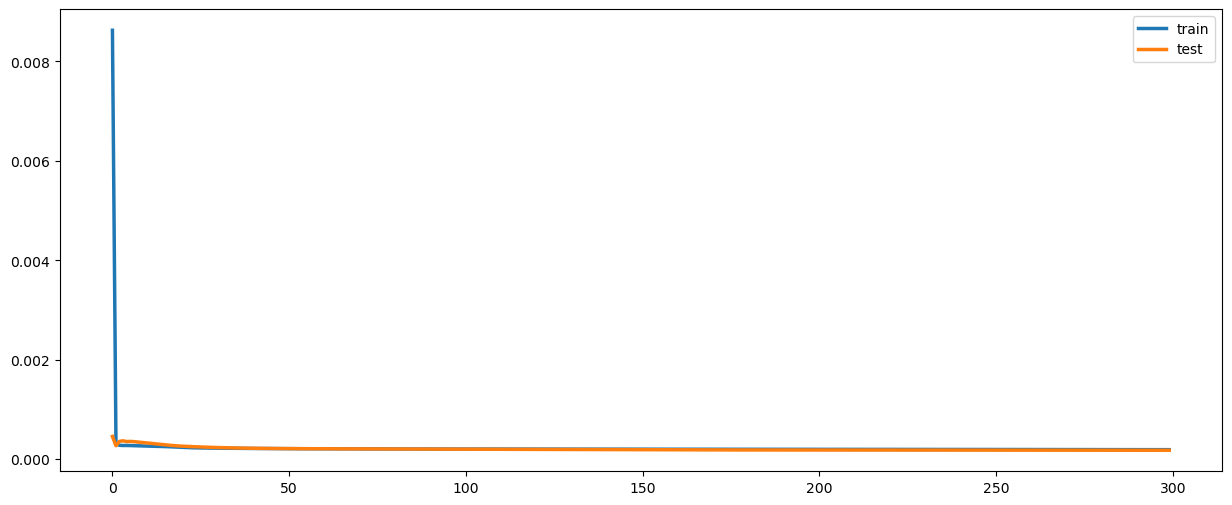

In [36]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [37]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 601us/step


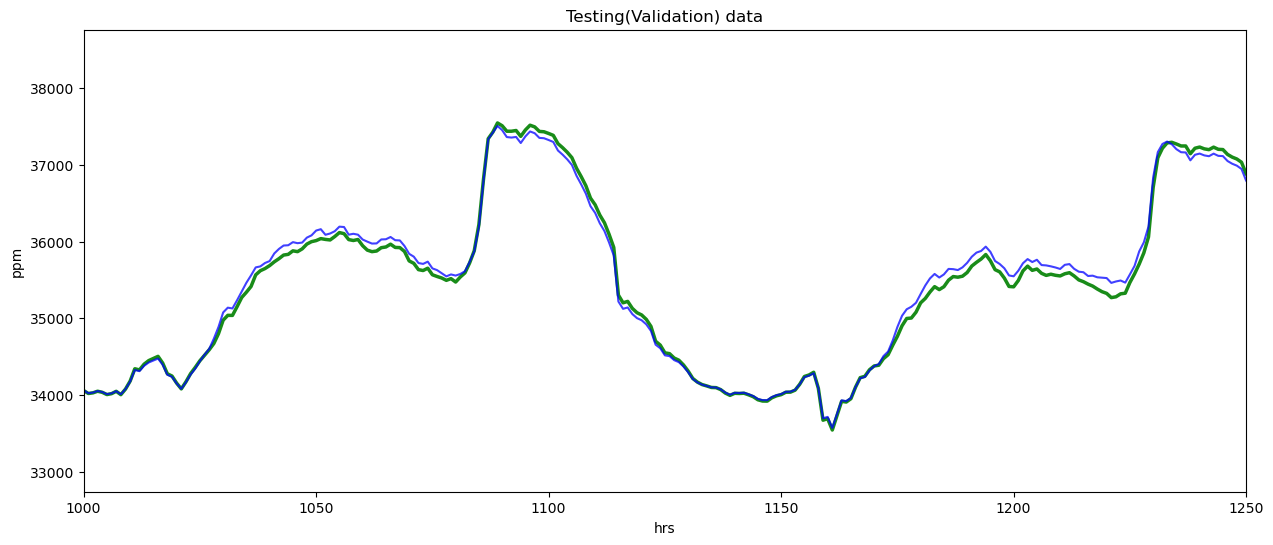

In [38]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [39]:
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 86.63636


In [40]:
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

MAPE: 0.21029990166425705 %


# Một lớp nhưng vẫn thêm dropout thì sẽ như nào

why we need drop:

The purpose of using dropout in neural networks, such as LSTM models, is to prevent overfitting and improve generalization performance. Here are a few reasons why dropout is beneficial:

Overfitting Prevention: Dropout helps prevent overfitting, which occurs when a model becomes too specialized and performs well on the training data but fails to generalize to new, unseen data. By randomly dropping out a fraction of input units during training, dropout introduces noise and prevents the model from relying too heavily on any specific set of features or neurons. This encourages the model to learn more robust and generalizable representations.

Reducing Co-Adaptation of Neurons: Dropout also reduces the co-adaptation of neurons. In a neural network, neurons can become highly interdependent and rely on each other to make decisions. Dropout disrupts this co-adaptation by randomly dropping out units, forcing the network to learn more independent and diverse representations. This makes the model more resilient and less sensitive to variations in the presence or absence of specific neurons.

Regularization: Dropout acts as a regularization technique. Regularization helps prevent overfitting by adding a penalty to the loss function, encouraging the model to have smaller weights or simpler representations. Dropout can be seen as a form of regularization that implicitly adds noise to the network, encouraging it to learn more generalizable patterns and avoid over-reliance on specific features.

Ensembling Effect: Dropout can be interpreted as an approximation of model ensembling. During training, dropout randomly disables a fraction of units, effectively training multiple sub-models with shared weights. At test time, the predictions are averaged or combined, mimicking the ensemble of multiple models. This ensemble effect can lead to improved performance and robustness.

By using dropout, you can improve the generalization capabilities of your LSTM model, reduce overfitting, and make it more robust to different inputs and variations in the data. It is a widely adopted technique to enhance the performance of neural networks, especially when dealing with complex models and limited training data.






In [41]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/100
1119/1119 - 3s - loss: 0.0108 - val_loss: 6.0738e-04 - 3s/epoch - 2ms/step
Epoch 2/100
1119/1119 - 1s - loss: 0.0020 - val_loss: 5.5143e-04 - 1s/epoch - 1ms/step
Epoch 3/100
1119/1119 - 1s - loss: 0.0015 - val_loss: 3.2907e-04 - 1s/epoch - 1ms/step
Epoch 4/100
1119/1119 - 1s - loss: 0.0012 - val_loss: 3.9700e-04 - 1s/epoch - 1ms/step
Epoch 5/100
1119/1119 - 1s - loss: 9.0431e-04 - val_loss: 3.2363e-04 - 1s/epoch - 1ms/step
Epoch 6/100
1119/1119 - 1s - loss: 7.3920e-04 - val_loss: 3.3495e-04 - 1s/epoch - 1ms/step
Epoch 7/100
1119/1119 - 1s - loss: 6.4775e-04 - val_loss: 3.1398e-04 - 1s/epoch - 1ms/step
Epoch 8/100
1119/1119 - 1s - loss: 5.9819e-04 - val_loss: 2.8672e-04 - 1s/epoch - 1ms/step
Epoch 9/100
1119/1119 - 1s - loss: 5.5338e-04 - val_loss: 2.8143e-04 - 1s/epoch - 1ms/step
Epoch 10/100
1119/1119 - 1s - loss: 5.4316e-04 - val_loss: 3.9478e-04 - 1s/epoch - 1ms/step
Epoch 11/100
1119/1119 - 1s - loss: 5.3035e-04 - val_loss: 3.2471e-04 - 1s/epoch - 1ms/step
Epoch 12/100


Epoch 91/100
1119/1119 - 1s - loss: 4.5217e-04 - val_loss: 2.0578e-04 - 1s/epoch - 1ms/step
Epoch 92/100
1119/1119 - 1s - loss: 4.5895e-04 - val_loss: 2.1381e-04 - 1s/epoch - 1ms/step
Epoch 93/100
1119/1119 - 1s - loss: 4.5225e-04 - val_loss: 2.0981e-04 - 1s/epoch - 1ms/step
Epoch 94/100
1119/1119 - 1s - loss: 4.5727e-04 - val_loss: 2.4891e-04 - 1s/epoch - 1ms/step
Epoch 95/100
1119/1119 - 1s - loss: 4.5892e-04 - val_loss: 2.0350e-04 - 1s/epoch - 1ms/step
Epoch 96/100
1119/1119 - 1s - loss: 4.5456e-04 - val_loss: 2.2801e-04 - 1s/epoch - 1ms/step
Epoch 97/100
1119/1119 - 1s - loss: 4.4946e-04 - val_loss: 2.3100e-04 - 1s/epoch - 1ms/step
Epoch 98/100
1119/1119 - 1s - loss: 4.5587e-04 - val_loss: 2.0477e-04 - 1s/epoch - 1ms/step
Epoch 99/100
1119/1119 - 1s - loss: 4.4777e-04 - val_loss: 2.0005e-04 - 1s/epoch - 1ms/step
Epoch 100/100
1119/1119 - 1s - loss: 4.4925e-04 - val_loss: 2.0016e-04 - 1s/epoch - 1ms/step


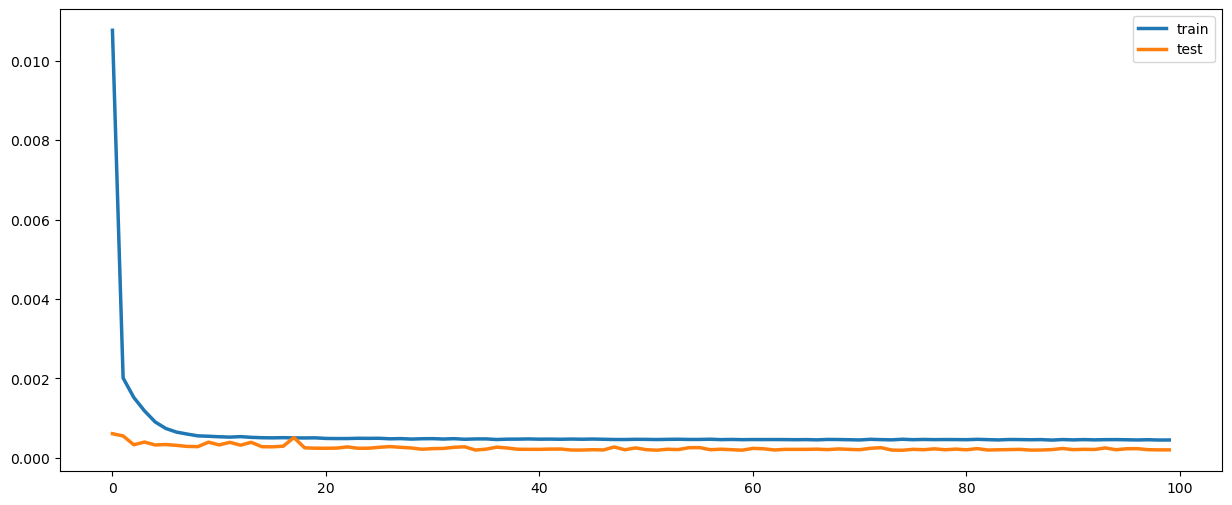

In [42]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [43]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 600us/step


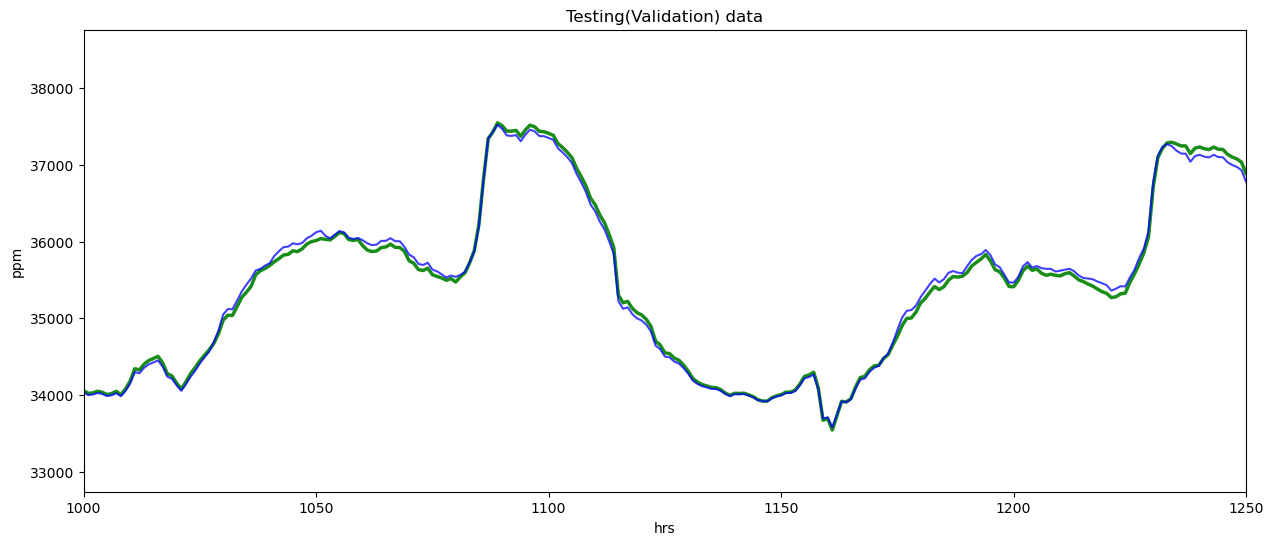

In [44]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [45]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 70.40343
MAPE: 0.16513976734131575 %


## Giảm số lượng epochs

In [46]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
1119/1119 - 3s - loss: 0.0102 - val_loss: 4.2364e-04 - 3s/epoch - 2ms/step
Epoch 2/50
1119/1119 - 1s - loss: 0.0020 - val_loss: 5.3259e-04 - 1s/epoch - 1ms/step
Epoch 3/50
1119/1119 - 1s - loss: 0.0015 - val_loss: 3.6219e-04 - 1s/epoch - 1ms/step
Epoch 4/50
1119/1119 - 1s - loss: 0.0012 - val_loss: 3.2319e-04 - 1s/epoch - 1ms/step
Epoch 5/50
1119/1119 - 1s - loss: 9.2191e-04 - val_loss: 3.3834e-04 - 1s/epoch - 1ms/step
Epoch 6/50
1119/1119 - 1s - loss: 7.4921e-04 - val_loss: 3.1959e-04 - 1s/epoch - 1ms/step
Epoch 7/50
1119/1119 - 1s - loss: 6.5340e-04 - val_loss: 3.7695e-04 - 1s/epoch - 1ms/step
Epoch 8/50
1119/1119 - 1s - loss: 5.9819e-04 - val_loss: 3.9330e-04 - 1s/epoch - 1ms/step
Epoch 9/50
1119/1119 - 1s - loss: 5.6234e-04 - val_loss: 3.4099e-04 - 1s/epoch - 1ms/step
Epoch 10/50
1119/1119 - 1s - loss: 5.3692e-04 - val_loss: 2.8563e-04 - 1s/epoch - 1ms/step
Epoch 11/50
1119/1119 - 1s - loss: 5.2706e-04 - val_loss: 4.7671e-04 - 1s/epoch - 1ms/step
Epoch 12/50
1119/1119 - 

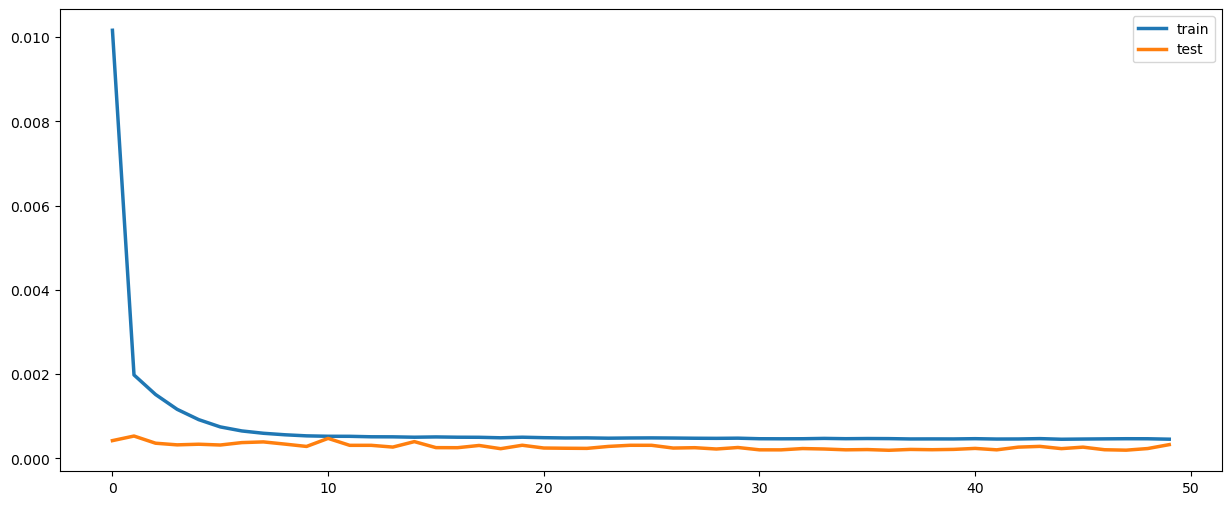

In [47]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [48]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 579us/step


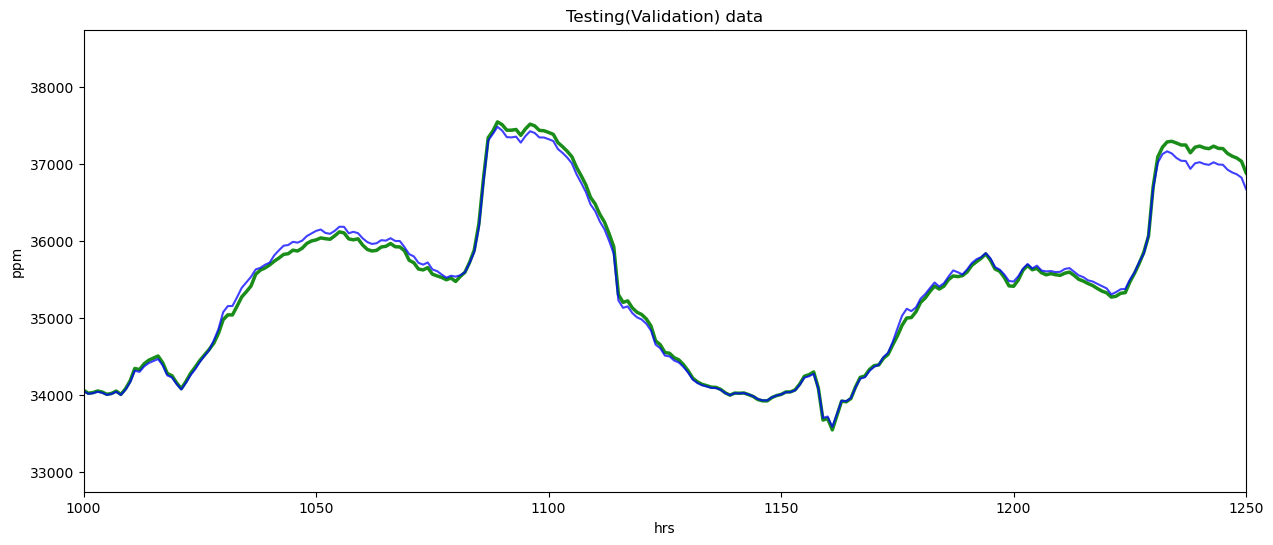

In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [50]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 97.649185
MAPE: 0.2237875247374177 %


# Tăng số lượng epochs

In [51]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/150
1119/1119 - 2s - loss: 0.0120 - val_loss: 4.5939e-04 - 2s/epoch - 2ms/step
Epoch 2/150
1119/1119 - 1s - loss: 0.0021 - val_loss: 3.0871e-04 - 1s/epoch - 1ms/step
Epoch 3/150
1119/1119 - 1s - loss: 0.0016 - val_loss: 4.1859e-04 - 1s/epoch - 1ms/step
Epoch 4/150
1119/1119 - 1s - loss: 0.0012 - val_loss: 3.1762e-04 - 1s/epoch - 1ms/step
Epoch 5/150
1119/1119 - 1s - loss: 9.2641e-04 - val_loss: 5.0553e-04 - 1s/epoch - 1ms/step
Epoch 6/150
1119/1119 - 1s - loss: 7.4880e-04 - val_loss: 3.1491e-04 - 1s/epoch - 1ms/step
Epoch 7/150
1119/1119 - 1s - loss: 6.5658e-04 - val_loss: 3.1360e-04 - 1s/epoch - 1ms/step
Epoch 8/150
1119/1119 - 1s - loss: 5.9120e-04 - val_loss: 3.8545e-04 - 1s/epoch - 1ms/step
Epoch 9/150
1119/1119 - 1s - loss: 5.5271e-04 - val_loss: 3.0300e-04 - 1s/epoch - 1ms/step
Epoch 10/150
1119/1119 - 1s - loss: 5.3737e-04 - val_loss: 2.9800e-04 - 1s/epoch - 1ms/step
Epoch 11/150
1119/1119 - 1s - loss: 5.2070e-04 - val_loss: 3.4949e-04 - 1s/epoch - 1ms/step
Epoch 12/150


Epoch 91/150
1119/1119 - 1s - loss: 4.6622e-04 - val_loss: 2.4347e-04 - 1s/epoch - 1ms/step
Epoch 92/150
1119/1119 - 1s - loss: 4.5567e-04 - val_loss: 2.0806e-04 - 1s/epoch - 1ms/step
Epoch 93/150
1119/1119 - 1s - loss: 4.5836e-04 - val_loss: 2.1310e-04 - 1s/epoch - 1ms/step
Epoch 94/150
1119/1119 - 1s - loss: 4.5741e-04 - val_loss: 2.0043e-04 - 1s/epoch - 1ms/step
Epoch 95/150
1119/1119 - 1s - loss: 4.5461e-04 - val_loss: 1.8766e-04 - 1s/epoch - 1ms/step
Epoch 96/150
1119/1119 - 1s - loss: 4.5546e-04 - val_loss: 2.2639e-04 - 1s/epoch - 1ms/step
Epoch 97/150
1119/1119 - 1s - loss: 4.5242e-04 - val_loss: 2.1557e-04 - 1s/epoch - 1ms/step
Epoch 98/150
1119/1119 - 1s - loss: 4.5269e-04 - val_loss: 2.4040e-04 - 1s/epoch - 1ms/step
Epoch 99/150
1119/1119 - 1s - loss: 4.5407e-04 - val_loss: 2.3183e-04 - 1s/epoch - 1ms/step
Epoch 100/150
1119/1119 - 1s - loss: 4.5111e-04 - val_loss: 2.0214e-04 - 1s/epoch - 1ms/step
Epoch 101/150
1119/1119 - 1s - loss: 4.6442e-04 - val_loss: 2.4054e-04 - 1s/epo

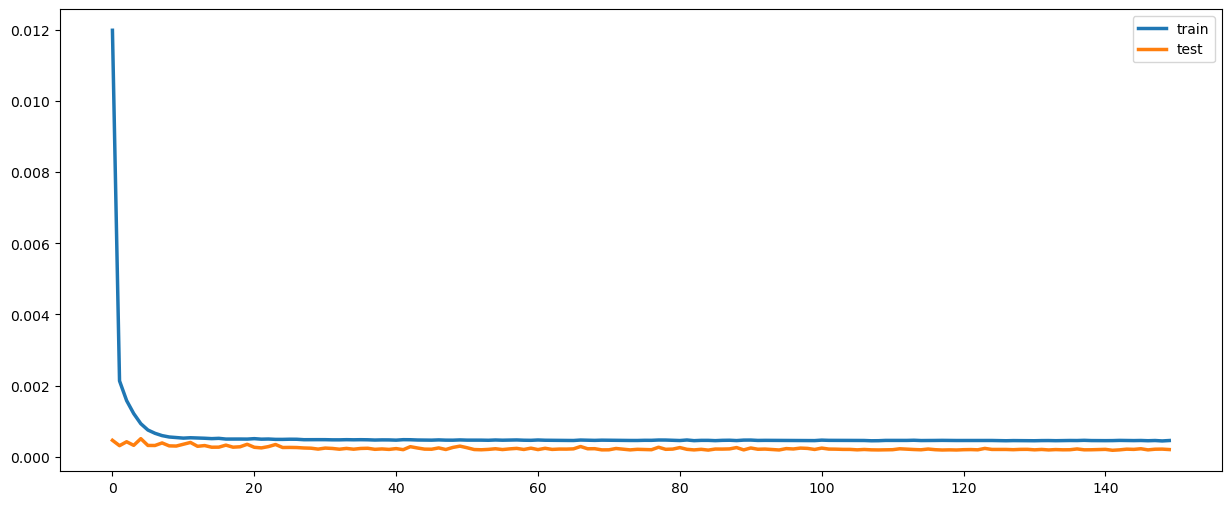

In [52]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [53]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 581us/step


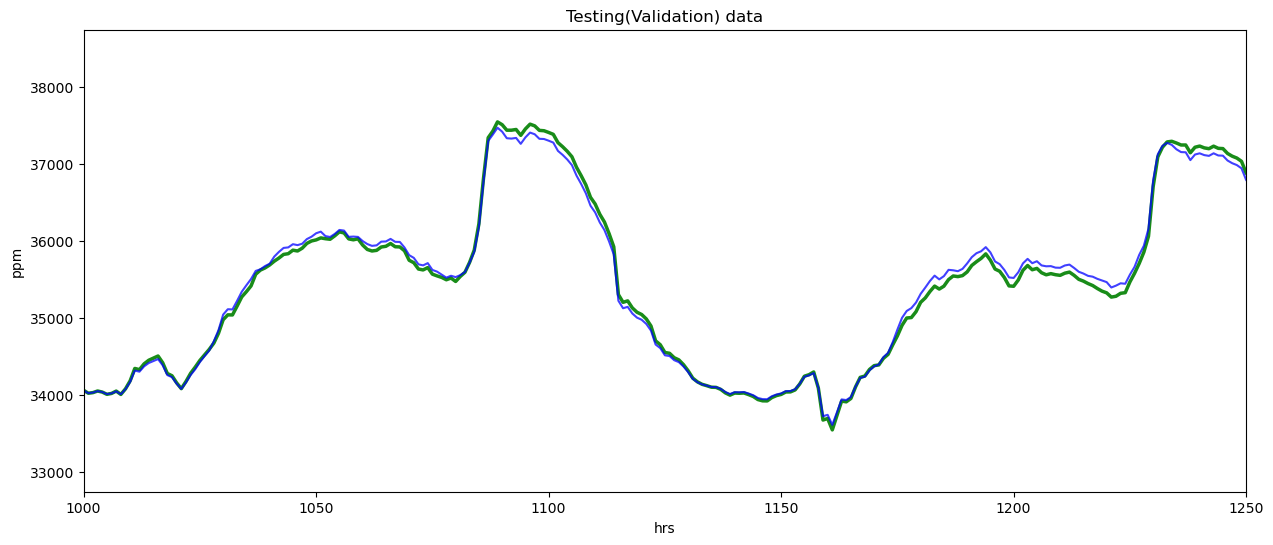

In [54]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [55]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 80.06399
MAPE: 0.19907576497644186 %


# Tăng số lượng epochs 


In [56]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/300
1119/1119 - 3s - loss: 0.0117 - val_loss: 6.6547e-04 - 3s/epoch - 2ms/step
Epoch 2/300
1119/1119 - 1s - loss: 0.0020 - val_loss: 3.1902e-04 - 1s/epoch - 1ms/step
Epoch 3/300
1119/1119 - 1s - loss: 0.0015 - val_loss: 5.4376e-04 - 1s/epoch - 1ms/step
Epoch 4/300
1119/1119 - 1s - loss: 0.0011 - val_loss: 3.7723e-04 - 1s/epoch - 1ms/step
Epoch 5/300
1119/1119 - 1s - loss: 8.9829e-04 - val_loss: 3.9157e-04 - 1s/epoch - 1ms/step
Epoch 6/300
1119/1119 - 1s - loss: 7.5373e-04 - val_loss: 3.4240e-04 - 1s/epoch - 1ms/step
Epoch 7/300
1119/1119 - 1s - loss: 6.3311e-04 - val_loss: 3.3183e-04 - 1s/epoch - 1ms/step
Epoch 8/300
1119/1119 - 1s - loss: 5.9121e-04 - val_loss: 3.7207e-04 - 1s/epoch - 1ms/step
Epoch 9/300
1119/1119 - 1s - loss: 5.5523e-04 - val_loss: 2.8473e-04 - 1s/epoch - 1ms/step
Epoch 10/300
1119/1119 - 1s - loss: 5.2762e-04 - val_loss: 3.4329e-04 - 1s/epoch - 1ms/step
Epoch 11/300
1119/1119 - 1s - loss: 5.2888e-04 - val_loss: 3.3414e-04 - 1s/epoch - 1ms/step
Epoch 12/300


Epoch 91/300
1119/1119 - 1s - loss: 4.6069e-04 - val_loss: 2.5204e-04 - 1s/epoch - 1ms/step
Epoch 92/300
1119/1119 - 1s - loss: 4.5172e-04 - val_loss: 2.1663e-04 - 1s/epoch - 1ms/step
Epoch 93/300
1119/1119 - 1s - loss: 4.6091e-04 - val_loss: 2.1776e-04 - 1s/epoch - 1ms/step
Epoch 94/300
1119/1119 - 1s - loss: 4.6000e-04 - val_loss: 2.0865e-04 - 1s/epoch - 1ms/step
Epoch 95/300
1119/1119 - 1s - loss: 4.5415e-04 - val_loss: 2.0707e-04 - 1s/epoch - 1ms/step
Epoch 96/300
1119/1119 - 1s - loss: 4.6667e-04 - val_loss: 2.1439e-04 - 1s/epoch - 1ms/step
Epoch 97/300
1119/1119 - 1s - loss: 4.5903e-04 - val_loss: 1.9178e-04 - 1s/epoch - 1ms/step
Epoch 98/300
1119/1119 - 1s - loss: 4.5734e-04 - val_loss: 2.0866e-04 - 1s/epoch - 1ms/step
Epoch 99/300
1119/1119 - 1s - loss: 4.5767e-04 - val_loss: 2.1154e-04 - 1s/epoch - 1ms/step
Epoch 100/300
1119/1119 - 1s - loss: 4.4963e-04 - val_loss: 1.9412e-04 - 1s/epoch - 1ms/step
Epoch 101/300
1119/1119 - 1s - loss: 4.5161e-04 - val_loss: 1.8918e-04 - 1s/epo

Epoch 180/300
1119/1119 - 1s - loss: 4.5427e-04 - val_loss: 1.8942e-04 - 1s/epoch - 1ms/step
Epoch 181/300
1119/1119 - 1s - loss: 4.4700e-04 - val_loss: 2.0353e-04 - 1s/epoch - 1ms/step
Epoch 182/300
1119/1119 - 1s - loss: 4.5171e-04 - val_loss: 2.0351e-04 - 1s/epoch - 1ms/step
Epoch 183/300
1119/1119 - 1s - loss: 4.4675e-04 - val_loss: 2.0614e-04 - 1s/epoch - 1ms/step
Epoch 184/300
1119/1119 - 1s - loss: 4.5167e-04 - val_loss: 1.8958e-04 - 1s/epoch - 1ms/step
Epoch 185/300
1119/1119 - 1s - loss: 4.4634e-04 - val_loss: 2.1856e-04 - 1s/epoch - 1ms/step
Epoch 186/300
1119/1119 - 1s - loss: 4.5446e-04 - val_loss: 1.9697e-04 - 1s/epoch - 1ms/step
Epoch 187/300
1119/1119 - 1s - loss: 4.5630e-04 - val_loss: 1.9583e-04 - 1s/epoch - 1ms/step
Epoch 188/300
1119/1119 - 1s - loss: 4.5520e-04 - val_loss: 1.9749e-04 - 1s/epoch - 1ms/step
Epoch 189/300
1119/1119 - 1s - loss: 4.5317e-04 - val_loss: 1.9166e-04 - 1s/epoch - 1ms/step
Epoch 190/300
1119/1119 - 1s - loss: 4.5221e-04 - val_loss: 1.9786e-04

1119/1119 - 1s - loss: 4.4882e-04 - val_loss: 2.1127e-04 - 1s/epoch - 1ms/step
Epoch 269/300
1119/1119 - 1s - loss: 4.3613e-04 - val_loss: 1.8452e-04 - 1s/epoch - 1ms/step
Epoch 270/300
1119/1119 - 1s - loss: 4.4956e-04 - val_loss: 1.9284e-04 - 1s/epoch - 1ms/step
Epoch 271/300
1119/1119 - 1s - loss: 4.4742e-04 - val_loss: 1.9221e-04 - 1s/epoch - 1ms/step
Epoch 272/300
1119/1119 - 1s - loss: 4.4070e-04 - val_loss: 1.9351e-04 - 1s/epoch - 1ms/step
Epoch 273/300
1119/1119 - 1s - loss: 4.4526e-04 - val_loss: 1.8053e-04 - 1s/epoch - 1ms/step
Epoch 274/300
1119/1119 - 1s - loss: 4.4586e-04 - val_loss: 1.8767e-04 - 1s/epoch - 1ms/step
Epoch 275/300
1119/1119 - 1s - loss: 4.4389e-04 - val_loss: 1.9632e-04 - 1s/epoch - 1ms/step
Epoch 276/300
1119/1119 - 1s - loss: 4.4812e-04 - val_loss: 1.9814e-04 - 1s/epoch - 1ms/step
Epoch 277/300
1119/1119 - 1s - loss: 4.4610e-04 - val_loss: 1.8268e-04 - 1s/epoch - 1ms/step
Epoch 278/300
1119/1119 - 1s - loss: 4.3822e-04 - val_loss: 1.8667e-04 - 1s/epoch - 

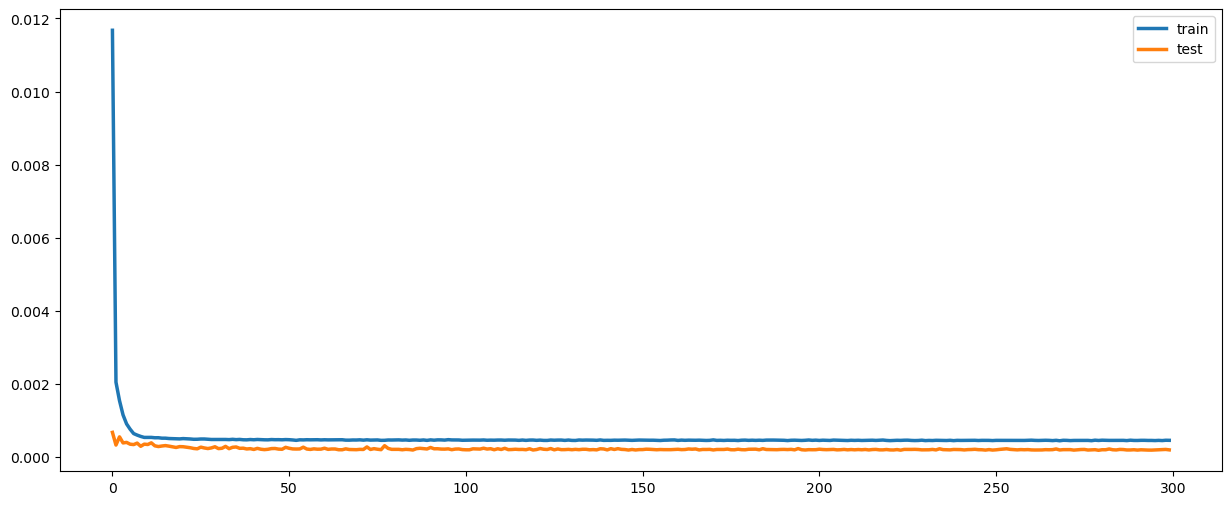

In [57]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [58]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 587us/step


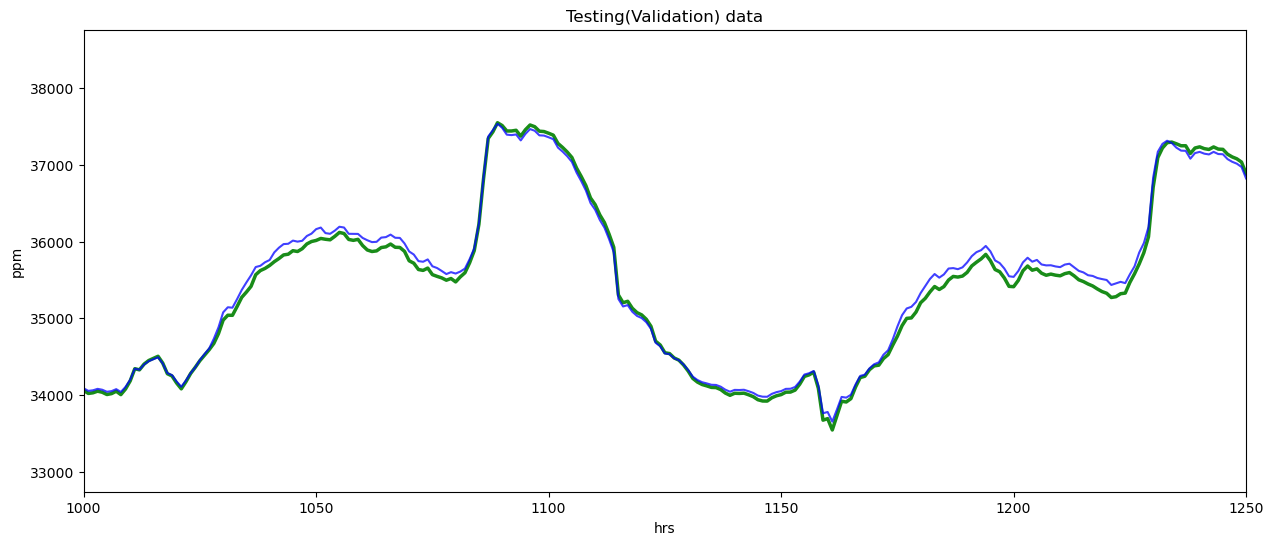

In [59]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [60]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 98.448166
MAPE: 0.24246626999229193 %


# Tiếp tục tăng số lượng epochs

In [61]:
model = Sequential()
model.add(LSTM(67, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/500
1119/1119 - 2s - loss: 0.0131 - val_loss: 4.1025e-04 - 2s/epoch - 2ms/step
Epoch 2/500
1119/1119 - 1s - loss: 0.0021 - val_loss: 4.6304e-04 - 1s/epoch - 1ms/step
Epoch 3/500
1119/1119 - 1s - loss: 0.0016 - val_loss: 3.4078e-04 - 1s/epoch - 1ms/step
Epoch 4/500
1119/1119 - 1s - loss: 0.0012 - val_loss: 2.9992e-04 - 1s/epoch - 1ms/step
Epoch 5/500
1119/1119 - 1s - loss: 9.1896e-04 - val_loss: 3.3786e-04 - 1s/epoch - 1ms/step
Epoch 6/500
1119/1119 - 1s - loss: 7.6703e-04 - val_loss: 3.3109e-04 - 1s/epoch - 1ms/step
Epoch 7/500
1119/1119 - 1s - loss: 6.5707e-04 - val_loss: 3.2302e-04 - 1s/epoch - 1ms/step
Epoch 8/500
1119/1119 - 1s - loss: 5.9198e-04 - val_loss: 3.2066e-04 - 1s/epoch - 1ms/step
Epoch 9/500
1119/1119 - 1s - loss: 5.6667e-04 - val_loss: 2.8178e-04 - 1s/epoch - 1ms/step
Epoch 10/500
1119/1119 - 1s - loss: 5.3412e-04 - val_loss: 2.8331e-04 - 1s/epoch - 1ms/step
Epoch 11/500
1119/1119 - 1s - loss: 5.3167e-04 - val_loss: 2.8466e-04 - 1s/epoch - 1ms/step
Epoch 12/500


Epoch 91/500
1119/1119 - 1s - loss: 4.5371e-04 - val_loss: 1.9402e-04 - 1s/epoch - 1ms/step
Epoch 92/500
1119/1119 - 1s - loss: 4.5245e-04 - val_loss: 2.2664e-04 - 1s/epoch - 1ms/step
Epoch 93/500
1119/1119 - 1s - loss: 4.5609e-04 - val_loss: 1.9693e-04 - 1s/epoch - 1ms/step
Epoch 94/500
1119/1119 - 1s - loss: 4.5789e-04 - val_loss: 1.9643e-04 - 1s/epoch - 1ms/step
Epoch 95/500
1119/1119 - 1s - loss: 4.5983e-04 - val_loss: 1.9239e-04 - 1s/epoch - 1ms/step
Epoch 96/500
1119/1119 - 1s - loss: 4.5602e-04 - val_loss: 1.9945e-04 - 1s/epoch - 1ms/step
Epoch 97/500
1119/1119 - 1s - loss: 4.5721e-04 - val_loss: 1.9324e-04 - 1s/epoch - 1ms/step
Epoch 98/500
1119/1119 - 1s - loss: 4.5712e-04 - val_loss: 1.9447e-04 - 1s/epoch - 1ms/step
Epoch 99/500
1119/1119 - 1s - loss: 4.5871e-04 - val_loss: 1.8984e-04 - 1s/epoch - 1ms/step
Epoch 100/500
1119/1119 - 1s - loss: 4.4812e-04 - val_loss: 1.9400e-04 - 1s/epoch - 1ms/step
Epoch 101/500
1119/1119 - 1s - loss: 4.5415e-04 - val_loss: 1.8960e-04 - 1s/epo

Epoch 180/500
1119/1119 - 1s - loss: 4.4855e-04 - val_loss: 1.9926e-04 - 1s/epoch - 1ms/step
Epoch 181/500
1119/1119 - 1s - loss: 4.4807e-04 - val_loss: 1.8575e-04 - 1s/epoch - 1ms/step
Epoch 182/500
1119/1119 - 1s - loss: 4.5136e-04 - val_loss: 2.1203e-04 - 1s/epoch - 1ms/step
Epoch 183/500
1119/1119 - 1s - loss: 4.5168e-04 - val_loss: 1.9879e-04 - 1s/epoch - 1ms/step
Epoch 184/500
1119/1119 - 1s - loss: 4.4322e-04 - val_loss: 2.0301e-04 - 1s/epoch - 1ms/step
Epoch 185/500
1119/1119 - 1s - loss: 4.4968e-04 - val_loss: 1.9055e-04 - 1s/epoch - 1ms/step
Epoch 186/500
1119/1119 - 1s - loss: 4.4686e-04 - val_loss: 1.9114e-04 - 1s/epoch - 1ms/step
Epoch 187/500
1119/1119 - 1s - loss: 4.4545e-04 - val_loss: 1.9391e-04 - 1s/epoch - 1ms/step
Epoch 188/500
1119/1119 - 1s - loss: 4.5207e-04 - val_loss: 1.9562e-04 - 1s/epoch - 1ms/step
Epoch 189/500
1119/1119 - 1s - loss: 4.5287e-04 - val_loss: 2.3162e-04 - 1s/epoch - 1ms/step
Epoch 190/500
1119/1119 - 1s - loss: 4.5092e-04 - val_loss: 1.9719e-04

1119/1119 - 1s - loss: 4.4225e-04 - val_loss: 1.8448e-04 - 1s/epoch - 1ms/step
Epoch 269/500
1119/1119 - 1s - loss: 4.3787e-04 - val_loss: 1.8308e-04 - 1s/epoch - 1ms/step
Epoch 270/500
1119/1119 - 1s - loss: 4.4273e-04 - val_loss: 2.1939e-04 - 1s/epoch - 1ms/step
Epoch 271/500
1119/1119 - 1s - loss: 4.5062e-04 - val_loss: 1.9761e-04 - 1s/epoch - 1ms/step
Epoch 272/500
1119/1119 - 1s - loss: 4.4480e-04 - val_loss: 2.0524e-04 - 1s/epoch - 1ms/step
Epoch 273/500
1119/1119 - 1s - loss: 4.5071e-04 - val_loss: 1.9532e-04 - 1s/epoch - 1ms/step
Epoch 274/500
1119/1119 - 1s - loss: 4.4543e-04 - val_loss: 2.0279e-04 - 1s/epoch - 1ms/step
Epoch 275/500
1119/1119 - 1s - loss: 4.4528e-04 - val_loss: 1.9682e-04 - 1s/epoch - 1ms/step
Epoch 276/500
1119/1119 - 1s - loss: 4.4600e-04 - val_loss: 2.0041e-04 - 1s/epoch - 1ms/step
Epoch 277/500
1119/1119 - 1s - loss: 4.4452e-04 - val_loss: 1.9888e-04 - 1s/epoch - 1ms/step
Epoch 278/500
1119/1119 - 1s - loss: 4.4270e-04 - val_loss: 1.8379e-04 - 1s/epoch - 

Epoch 357/500
1119/1119 - 1s - loss: 4.3502e-04 - val_loss: 1.9315e-04 - 1s/epoch - 1ms/step
Epoch 358/500
1119/1119 - 1s - loss: 4.4277e-04 - val_loss: 1.9595e-04 - 1s/epoch - 1ms/step
Epoch 359/500
1119/1119 - 1s - loss: 4.4309e-04 - val_loss: 1.8495e-04 - 1s/epoch - 1ms/step
Epoch 360/500
1119/1119 - 1s - loss: 4.3853e-04 - val_loss: 2.2491e-04 - 1s/epoch - 1ms/step
Epoch 361/500
1119/1119 - 1s - loss: 4.4440e-04 - val_loss: 2.0221e-04 - 1s/epoch - 1ms/step
Epoch 362/500
1119/1119 - 1s - loss: 4.4051e-04 - val_loss: 1.9521e-04 - 1s/epoch - 1ms/step
Epoch 363/500
1119/1119 - 1s - loss: 4.3885e-04 - val_loss: 1.8811e-04 - 1s/epoch - 1ms/step
Epoch 364/500
1119/1119 - 1s - loss: 4.4425e-04 - val_loss: 2.0121e-04 - 1s/epoch - 1ms/step
Epoch 365/500
1119/1119 - 1s - loss: 4.4477e-04 - val_loss: 1.9918e-04 - 1s/epoch - 1ms/step
Epoch 366/500
1119/1119 - 1s - loss: 4.4151e-04 - val_loss: 1.9481e-04 - 1s/epoch - 1ms/step
Epoch 367/500
1119/1119 - 1s - loss: 4.4144e-04 - val_loss: 1.8695e-04

1119/1119 - 1s - loss: 4.3937e-04 - val_loss: 2.0508e-04 - 1s/epoch - 1ms/step
Epoch 446/500
1119/1119 - 1s - loss: 4.3877e-04 - val_loss: 1.9105e-04 - 1s/epoch - 1ms/step
Epoch 447/500
1119/1119 - 1s - loss: 4.4578e-04 - val_loss: 1.9412e-04 - 1s/epoch - 1ms/step
Epoch 448/500
1119/1119 - 1s - loss: 4.3891e-04 - val_loss: 1.8939e-04 - 1s/epoch - 1ms/step
Epoch 449/500
1119/1119 - 1s - loss: 4.3473e-04 - val_loss: 1.8723e-04 - 1s/epoch - 1ms/step
Epoch 450/500
1119/1119 - 1s - loss: 4.4468e-04 - val_loss: 1.7468e-04 - 1s/epoch - 1ms/step
Epoch 451/500
1119/1119 - 1s - loss: 4.4093e-04 - val_loss: 1.9338e-04 - 1s/epoch - 1ms/step
Epoch 452/500
1119/1119 - 1s - loss: 4.4454e-04 - val_loss: 1.9113e-04 - 1s/epoch - 1ms/step
Epoch 453/500
1119/1119 - 1s - loss: 4.4279e-04 - val_loss: 1.8458e-04 - 1s/epoch - 1ms/step
Epoch 454/500
1119/1119 - 1s - loss: 4.3978e-04 - val_loss: 1.8587e-04 - 1s/epoch - 1ms/step
Epoch 455/500
1119/1119 - 1s - loss: 4.3976e-04 - val_loss: 1.8748e-04 - 1s/epoch - 

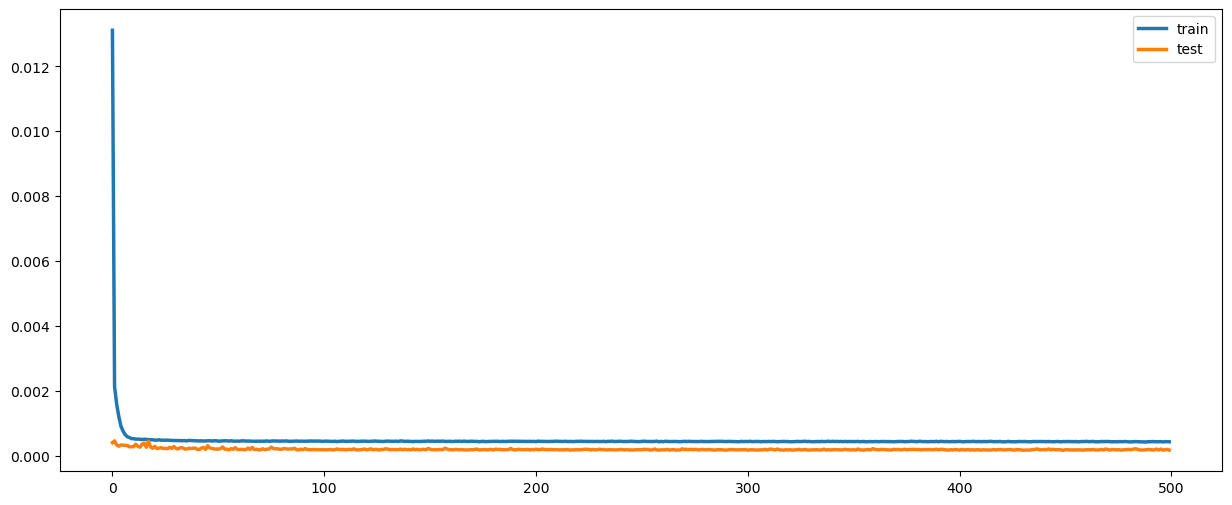

In [62]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [63]:
testPredict = model.predict(test_X)
testPredict = testPredict.ravel()

y_test_true = test[:,5]
zone_1 = np.array(df["Zone 1 Power Consumption"])
meanop = zone_1.mean()
stdop = zone_1.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))


328/328 [==============================] - 0s 554us/step


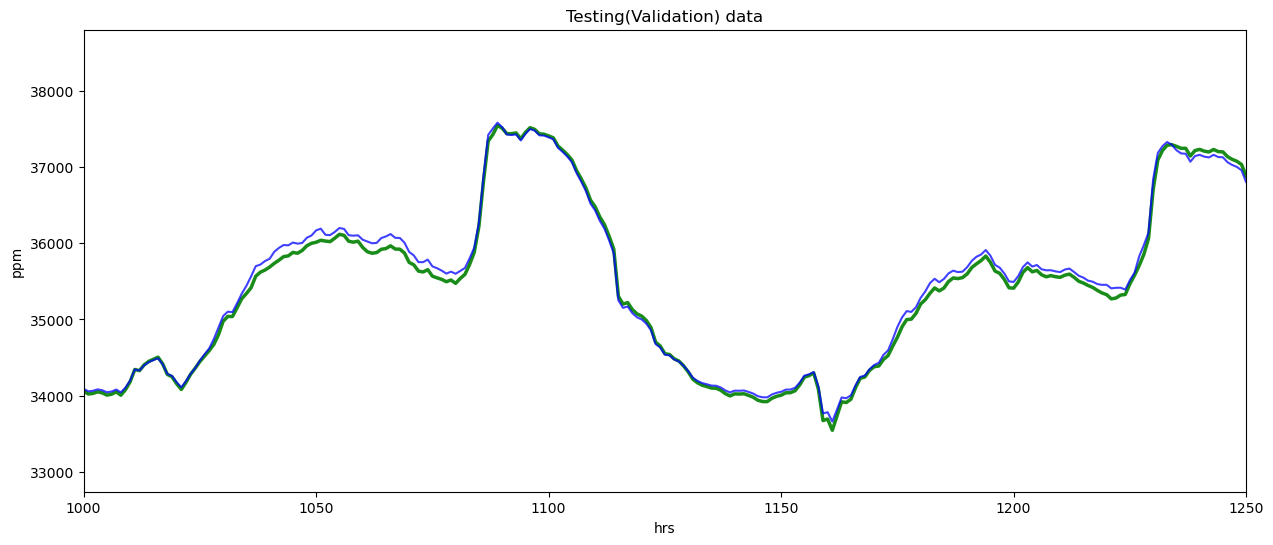

In [64]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [65]:
print("Test(Validation) RMSE ="  ,rmse)
# Tính toán MAPE 
mape = mean_absolute_percentage_error(y_test_true, testPredict) * 100
print('MAPE:', mape, '%')

Test(Validation) RMSE = 95.338486
MAPE: 0.22825568448752165 %
